In [1]:
from scipy.ndimage import affine_transform
import tifffile as tiff
import os
import numpy as np
import copy
from pathlib import Path
import sys
import matplotlib.pyplot as plt

PIPELINE_ROOT =  Path().resolve().parent.parent
sys.path.append(PIPELINE_ROOT.as_posix())

In [2]:
from library.image_manipulation.pipeline_process import Pipeline
from library.image_manipulation.elastix_manager import create_downsampled_transforms
from library.utilities.utilities_registration import (
    parameters_to_rigid_transform,
    rigid_transform_to_parmeters,
)
#from settings import host, password, user, schema
channel = 1
downsample = True
tg = False
debug = False
rescan_number = 0
task = 'align'

In [3]:
class ManualAligner(Pipeline):
    
    def __init__(self, animal, moving_index):
        #animal, channel, downsample, data_path, tg, debug
        #animal, rescan_number, channel, downsample, tg, debug, task):

        super().__init__(animal, rescan_number, channel, downsample, tg, debug, task)
        self.sections = self.sqlController.get_sections(self.animal, self.channel, rescan_number)
        section = moving_index
        self.midpoint = len(self.sections) // 2
        self.moving_index = moving_index
        self.fixed_index = moving_index - 1
        INPUT = os.path.join(self.fileLocationManager.prep, 'CH1', 'thumbnail_aligned_iteration_2')
        self.moving_file = os.path.join(INPUT, f'{str(moving_index).zfill(3)}.tif')
        self.fixed_file = os.path.join(INPUT, f'{str(self.fixed_index).zfill(3)}.tif')
        self.moving = tiff.imread(self.moving_file)
        self.fixed = tiff.imread(self.fixed_file)
        self.transformation_to_previous_sec = self.get_transformation_to_previous_section()
        self.center = self.get_rotation_center()
        
    def transform_image(self,img,T):
        matrix = T[:2,:2]
        offset = T[:2,2]
        offset = np.flip(offset)
        img = affine_transform(img,matrix.T,offset)
        return img
    
    def evalulate_transformation(self,img1,img2,T1,T2):
        img1 = self.transform_image(img1,T1)
        img2 = self.transform_image(img2,T2)
        self.compare_two_image(img1,img2)        
        
    def compare_two_image(self,img1,img2):
        img1,img2 = img1.astype(float),img2.astype(float)
        vmin_max1 = img1[img1!=0].min(),img1[img1!=0].max()
        vmin_max2 = img2[img2!=0].min(),img2[img2!=0].max()
        img1[img1<2000]=np.nan
        img2[img2<2000]=np.nan
        plt.figure(figsize=[20,20])
        plt.imshow(img1,cmap='Blues',vmin=vmin_max1[0], vmax=vmin_max1[1]*0.8)
        plt.imshow(img2,alpha=0.5,cmap='Reds',vmin=vmin_max2[0], vmax=vmin_max2[1]*0.8)
        
    def get_transformation_to_previous_section(self):
        transformation_to_previous_sec = {}
        center = self.get_rotation_center()
        for i in range(1, len(self.sections)):
            rotation, xshift, yshift = self.load_elastix_transformation(self.animal, i, iteration=3)
            T = parameters_to_rigid_transform(rotation, xshift, yshift, center)
            transformation_to_previous_sec[i] = T
        return transformation_to_previous_sec

    def get_transformation_of_sectioni_to_midpoint(self, sectioni, transformations):
        if sectioni == self.midpoint:
            transformation = np.eye(3)
        elif sectioni < self.midpoint:
            T_composed = np.eye(3)
            for i in range(self.midpoint, sectioni, -1):
                T_composed = np.dot(np.linalg.inv(transformations[i]), T_composed)
                # print(f'midpoint={self.midpoint}, i={i}, section={sectioni}')
            transformation = T_composed
        else:
            # original
            T_composed = np.eye(3)
            for i in range(self.midpoint + 1, sectioni + 1):
                #print(f'midpoint={self.midpoint}, i={i}, section={sectioni}')
                T_composed = np.dot(transformations[i], T_composed)
            transformation = T_composed
            
        
        return transformation
    

    def get_transformation_of_sectioni(self,sectioni):
        transformation = self.get_transformation_of_sectioni_to_midpoint(
            sectioni, self.transformation_to_previous_sec)
        return transformation

    def get_modified_transformation_of_sectioni(self, fixed_index, rotation, xshift, yshift):
        T = parameters_to_rigid_transform(rotation, xshift, yshift, self.center)
        transformation_to_previous_sec = copy.copy(self.transformation_to_previous_sec)
        transformation_to_previous_sec[fixed_index+1] = T
        transformation = self.get_transformation_of_sectioni_to_midpoint(
            fixed_index, transformation_to_previous_sec)
        return transformation
    
    def compare_untransformed(self):
        self.compare_two_image(self.moving,self.fixed)
        
    # def get_current_transformation_parameters(self):
    #     T = self.transformation_to_previous_sec[self.moving_index]
    #     return rigid_transform_to_parmeters(T,self.center)
    
    def evaluate_current_transformation(self):
        T1 = self.get_transformation_of_sectioni(self.moving_index)
        T2 = self.get_transformation_of_sectioni(self.fixed_index)
        self.evalulate_transformation(self.moving, self.fixed, T1, T2)
        plt.title(self.moving_index);

In [7]:
prep_id = 'CTB004'
section = 102
aligner = ManualAligner(prep_id, section)
print(f'fixed index={aligner.fixed_index}')
print(f'moving index={aligner.moving_index}')

RUNNING PREPROCESSING-PIPELINE WITH THE FOLLOWING SETTINGS:
	prep_id:            CTB004              
	rescan_number:      0                   
	channel:            1                   
	downsample:         False                @ 32.0              
	host:               localhost           
	schema:             brainsharer         
	tg:                 False               
	debug:              False               

fixed index=101
moving index=102


In [ ]:
#aligner.compare_untransformed()

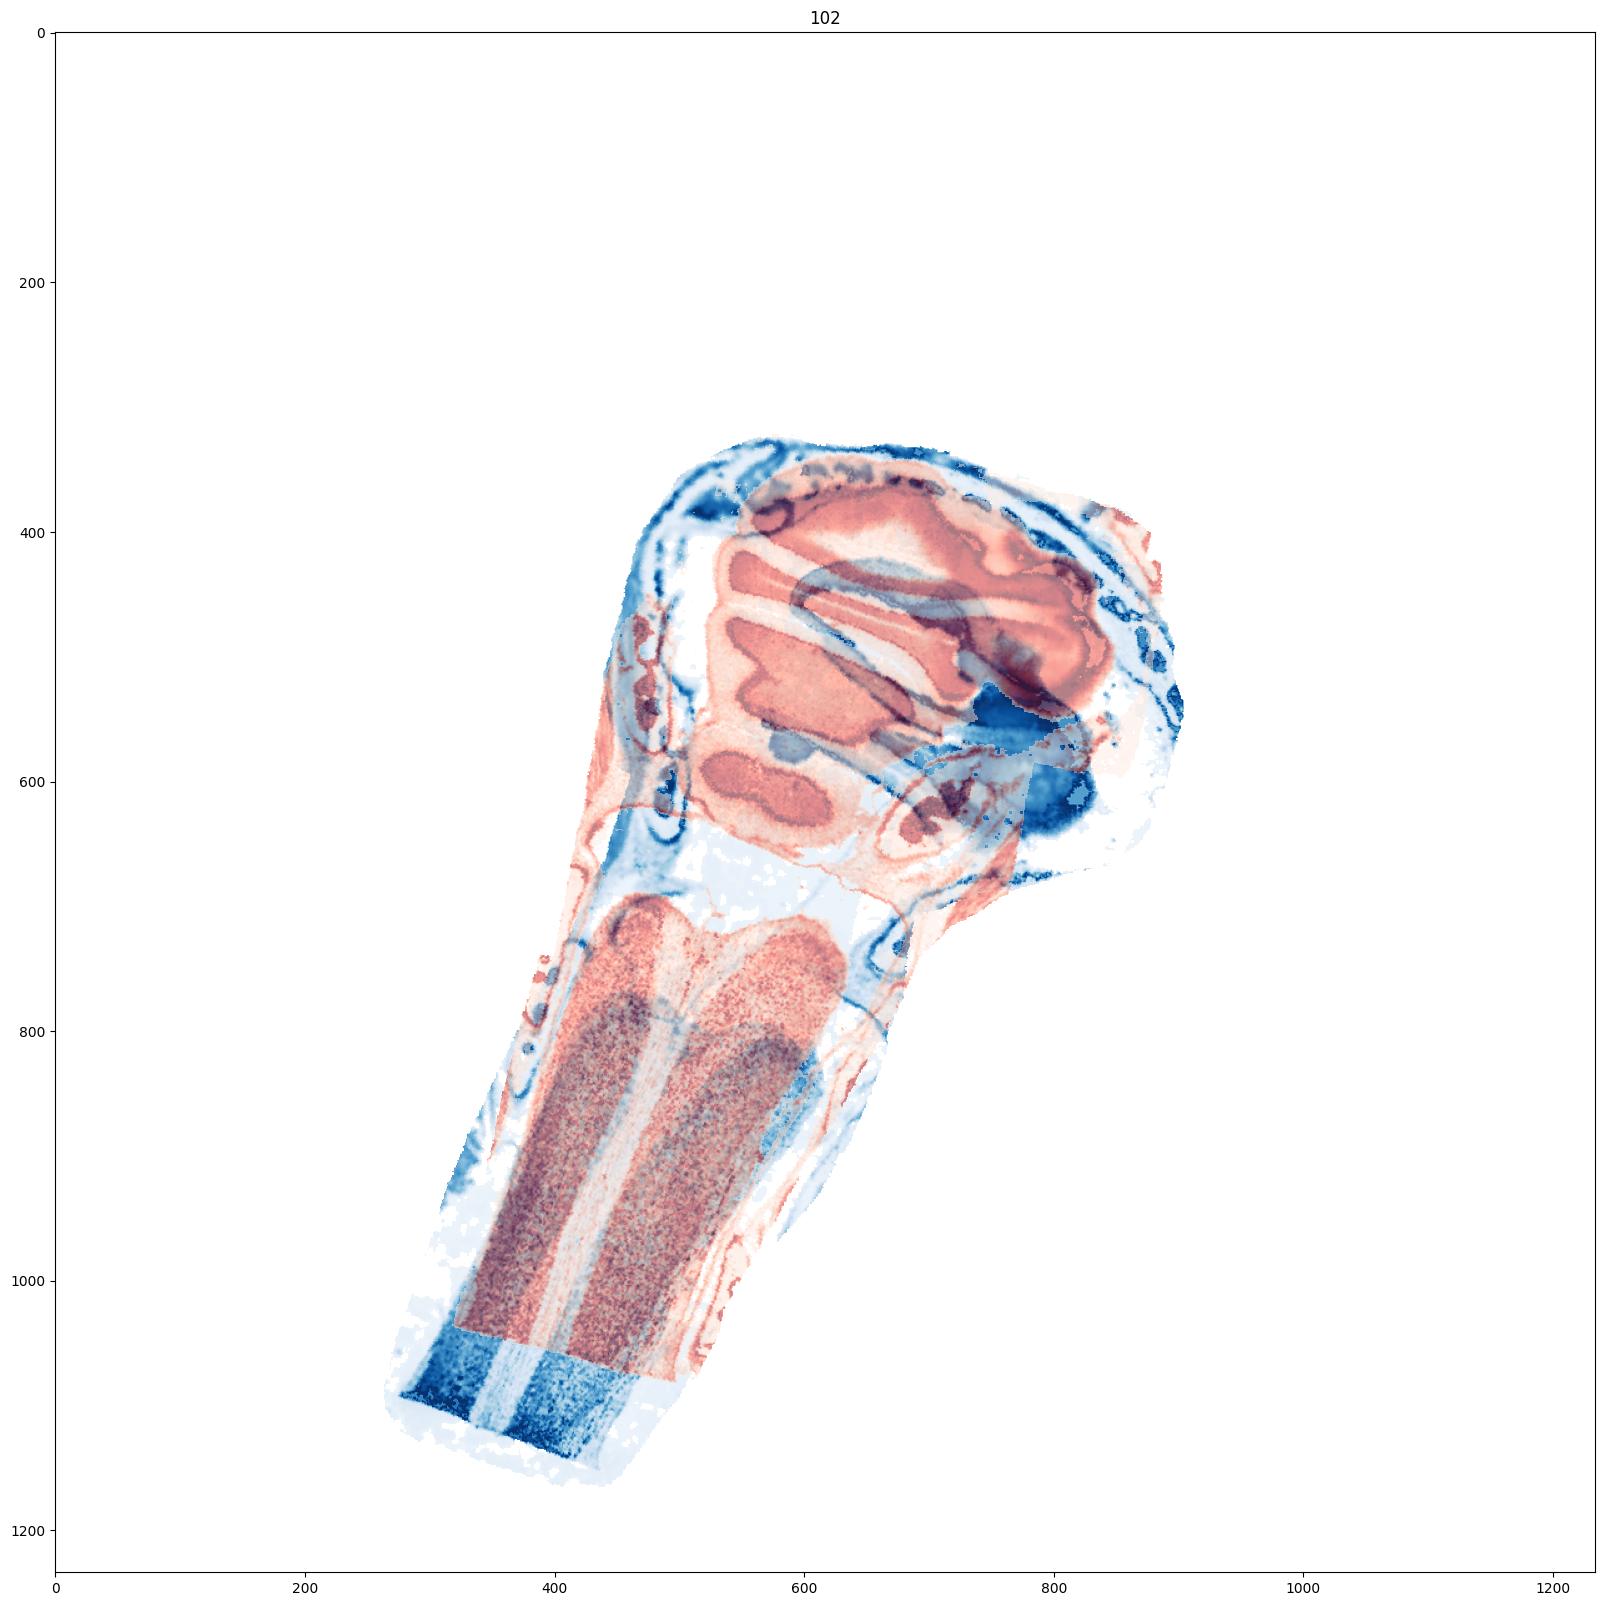

In [8]:
aligner.evaluate_current_transformation()

In [9]:
rotation, xshift, yshift = aligner.load_elastix_transformation(aligner.animal, aligner.moving_index, iteration=1)
section = str(aligner.moving_index).zfill(3)
print(f'fixed index = {aligner.fixed_index}')
print(f'moving index/section = {aligner.moving_index}')
print(f'rotation = {rotation}')
print(f'xshift = {xshift}')
print(f'yshift = {yshift}')

fixed index = 101
moving index/section = 102
rotation = -0.00749233
xshift = -0.52602
yshift = -0.11961


In [ ]:
## changing these changes the red image:
## increasing the rotation rotates the red image clockwise
## increasing x moves the red image to the right.
## increasing y moves the red image down
## The red image is the previous image (fixed image)
rotation = 0.000236907
xshift = -4.65016
yshift = 1000
T1 = aligner.get_transformation_of_sectioni(aligner.moving_index)
#T2 = aligner.get_transformation_of_sectioni(aligner.fixed_index)
T2 = aligner.get_modified_transformation_of_sectioni(aligner.fixed_index, rotation, xshift, yshift)
aligner.evalulate_transformation(aligner.moving, aligner.fixed, T1, T2)
title = f'Moving blue section {section} on {prep_id} rotation={rotation}, xshift={xshift}, yshift={yshift}'
plt.title(title);

In [ ]:
print(f'section={section}')
fig, ax = plt.subplots(1,2)
fig.set_figheight(15)
fig.set_figwidth(15)
ax[0].grid()
ax[1].grid()
ax[0].title.set_text(f'fixed {aligner.fixed_index}')
ax[1].title.set_text(f'moving {aligner.moving_index}')
ax[0].imshow(aligner.fixed, cmap="gray")
ax[1].imshow(aligner.moving, cmap="gray")

In [ ]:
sql = f'UPDATE elastix_transformation SET rotation={rotation}, xshift={xshift}, yshift={yshift} \
     \nWHERE section = \'{section}\' and FK_prep_id = \'{prep_id}\' and iteration=1 \nLIMIT 1'
print(sql)